<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-Studentized-Bootstrap" data-toc-modified-id="The-Studentized-Bootstrap-1">The Studentized Bootstrap</a></span><ul class="toc-item"><li><span><a href="#Repair-Times" data-toc-modified-id="Repair-Times-1.1">Repair Times</a></span></li><li><span><a href="#Comparing-Distributions-of-the-Statistic" data-toc-modified-id="Comparing-Distributions-of-the-Statistic-1.2">Comparing Distributions of the Statistic</a></span></li><li><span><a href="#The-Studentized-Bootstrap-Procedure" data-toc-modified-id="The-Studentized-Bootstrap-Procedure-1.3">The Studentized Bootstrap Procedure</a></span></li><li><span><a href="#Computing-the-Standard-Error-of-the-Resample-Statistic" data-toc-modified-id="Computing-the-Standard-Error-of-the-Resample-Statistic-1.4">Computing the Standard Error of the Resample Statistic</a></span></li><li><span><a href="#Comparison-of-Studentized-Bootstrap-with-Percentile-Bootstrap" data-toc-modified-id="Comparison-of-Studentized-Bootstrap-with-Percentile-Bootstrap-1.5">Comparison of Studentized Bootstrap with Percentile Bootstrap</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2">Summary</a></span></li></ul></div>

In [77]:
# HIDDEN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [78]:
# HIDDEN
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]
    if len(df.columns) <= ncols:
        interact(peek, row=(0, len(df) - nrows, nrows), col=fixed(0))
    else:
        interact(peek,
                 row=(0, len(df) - nrows, nrows),
                 col=(0, len(df.columns) - ncols))
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

In [79]:
# Generate a bunch of random points. To change the dataset, just
# change this line and rerun notebook
times = (np.random.exponential(scale=300, size=13825) +
         np.abs(np.random.normal(loc=50, scale=40, size=13825)))

## The Studentized Bootstrap



- Briefly review percentile bootstrap confidence interval procedure
    - Make distinction to call this the "percentile bootstrap" method since we will introduce a new method in this section.
- Briefly review bootstrap CI confidence meaning
    - 95% confidence = 95% probability that taking a new sample from population and making bootstrap CI will have the parameter
- However, this probability is not exactly 95%

- We've taken a population and created one thousand bootstrap CIs for the population mean at each sample size from 4 to 100.
    - Notice that at sample sizes below 20, fewer than 90% of the CIs actually contain the population parameter, not 95%.

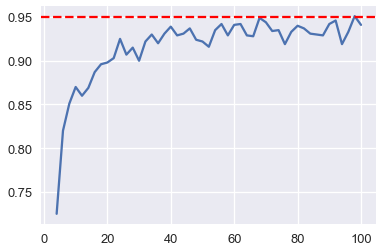

In [100]:
# Since this plot needs a bunch of prior code to run, I suggest
# saving this plot as a .png and then just including the picture without the
# code in the final notebook
trials['percentile'].plot()
plt.axhline(0.95, c='red', linestyle='--', label='95% coverage');

- Coverage error is the difference between the desired 95% confidence and reality.
- We can see that the coverage error for our bootstrap method is rather high at small sample sizes.
- We will introduce a new bootstrap method that has lower coverage error but requires more computation.

### Repair Times

- Introduce dataset: population of repair times (need Deb for more background)
- Plot data


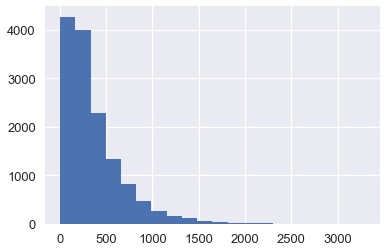

In [80]:
plt.hist(times, bins=20);

- We are estimating the population mean

In [81]:
def stat(sample, axis=None):
    return np.mean(sample, axis=axis)

In [82]:
theta = stat(times)
theta

359.24125190232576

- Define method to take sample of size 10 from population

In [101]:
def take_sample(n=10):
    return np.random.choice(times, size=n, replace=False)

- Normally, we aren't able to draw many samples from the population. This time, we have access to the population so we will take many samples of size 10 and plot the distribution of sample means:

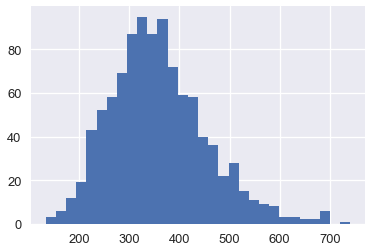

In [136]:
samples_from_pop = 1000

pop_sampling_dist = np.array(
    [stat(take_sample()) for _ in range(samples_from_pop)]
)

plt.hist(pop_sampling_dist, bins=30);

- We see that this distribution is slightly skewed right because of the skewed distribution of the original data.

### Comparing Distributions of the Statistic

- We use $ \theta $ to refer to the population parameter
    - In this case, the average repair time
- We use $ \hat \theta $ to refer to the sample statistic
    - In this case, the average repair time of a sample.
    - The plot above shows an empirical distribution of $ \hat \theta $.
- Recall that the bootstrap procedure takes a resample of the original sample. For each resample, we calculate $ \tilde \theta $, the statistic of the resample.
    - In this case, the average repair time of a resample.
- In order for the bootstrap to work, we need the sample to look similar to the population so that the resample also looks similar to the population.
- If this is true, the distribution of average repair times using the resamples will look similar to the distribution of average repair times using multiple samples from the population.


- We now take a sample of size 10 and bootstrap it 1000 times, plotting the distribution of $ \tilde \theta $.

In [113]:
def resample(sample, reps):
    n = len(sample)
    return np.random.choice(sample, size=reps * n).reshape((reps, n))

def bootstrap_stats(sample, reps=1000, stat=stat):
    resamples = resample(sample, reps)
    return stat(resamples, axis=1)

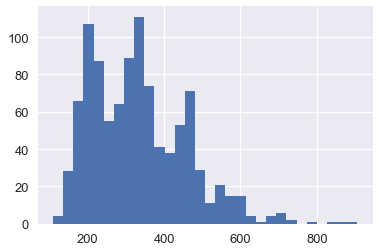

In [114]:
np.random.seed(0)

sample = take_sample()

plt.hist(bootstrap_stats(sample), bins=30);

- As you can see, the distribution of $ \tilde \theta $ doesn't look like the distribution of $ \hat \theta $.
- This causes the percentile CI to perform poorly.
- Side-by-side comparison:

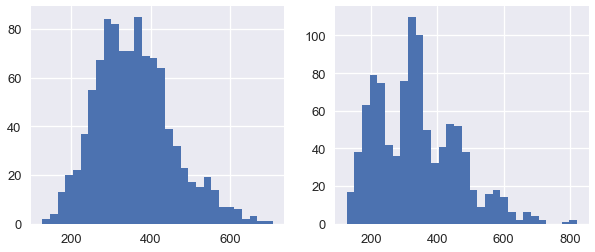

In [118]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.hist(pop_sampling_dist, bins=30);

plt.subplot(122)
plt.hist(bootstrap_stats(sample), bins=30);

### The Studentized Bootstrap Procedure

- Idea: normalize the distribution of the test statistic $ \tilde \theta $ to be centered at 0 and have a standard deviation of 1.
- This corrects for the spread difference and skew of the test statistic distribution. (Probably want more clarification from Deb here.)
- However, we will need some derivation to make this work

- In the percentile method, we generate many values of $ \tilde \theta $, then take the 2.5th and 97.5th percentiles of these values for our CI.
    - We use the notation $ q_{2.5} $ and $ q_{97.5} $ to refer to these percentiles.
    - Note that both of these values come from the bootstrap statistics

- We hope that:

$$
\begin{aligned}
0.95 &= {\cal P}\left(q_{2.5} \leq \theta \leq q_{97.5}\right)
\end{aligned}
$$

- That is, we hope that the population parameter has a 95% chance of being in a confidence interval created from a new sample from the population.
- We make two approximations: since a random sample looks like the population, we approximate $ \theta $ with $ \hat \theta $. Since a random resample looks like the original sample, we we approximate $ \hat \theta $ with $ \tilde \theta $.
- These approximations introduce error into the CI generation which results in the coverage error we see above.

- We reduce this error by normalizing our statistic.
    - instead of using $ \tilde \theta $ directly, we use:
    
$$
\begin{aligned}
\frac
    {\tilde{\theta} - {\hat{\theta}}}
    {SE({\tilde{\theta}})}
\end{aligned}
$$

- First, we normalize the statistic by the sample statistic
- Then, we divide by the standard deviation of the resample statistic (also called the standard error, or SE).
- This normalized statistic is called the Student's t-statistic, so we call this bootstrap method the Studentized bootstrap or the bootstrap-$t$ method.

- As usual, we compute many of these statistics, then take the 2.5th and 97.5th percentiles — $ q_{2.5} $ and $ q_{97.5} $.
- We hope that the normalized population parameter lies between these percentiles:

$$
\begin{aligned}
0.95 &= {\cal P}\left(q_{2.5} \leq \frac{\hat{\theta} - \theta} {SE({\hat{\theta}})} \leq q_{97.5}\right) \\
\end{aligned}
$$

- Solving the inequality for $ \theta $:

$$
\begin{aligned}
0.95 &= {\cal P}\left(q_{2.5} \leq \frac{\hat{\theta} - \theta} {SE({\hat{\theta}})} \leq q_{97.5}\right) \\
 &= {\cal P}\left(q_{2.5}SE({\hat{\theta}}) \leq {\hat{\theta} - \theta} \leq q_{97.5}SE({\hat{\theta}})\right) \\
 &= {\cal P}\left(\hat{\theta} - q_{97.5}SE({\hat{\theta}}) \leq {\theta} \leq \hat{\theta} - q_{2.5}SE({\hat{\theta}})\right) 
\end{aligned}
$$

- This means we can create a 95% confidence interval using:
    - $ \hat{\theta} $, the test statistic computed on the sample.
    - $ q_{2.5} $ and $ q_{97.5} $, the percentiles of the normalized statistic computed on the resamples.
    - $ SE(\hat \theta) $, the standard deviation of the sample test statistic. We estimate this quantity by using the standard deviation of the resample test statistics.

- Thus, to compute a studentized bootstrap CI, we perform the following procedure:


1. Compute $ \hat{\theta} $, the test statistic on the sample.
1. Bootstrap the sample a large number of times.
1. For each bootstrap resample:
    1. Compute $ \tilde \theta $, the test statistic on the resample.
    1. Compute $ SE({\tilde{\theta}}) $.
    1. Compute $ q =  \frac{\tilde{\theta} - {\hat{\theta}}}{SE({\tilde{\theta}})} $.
1. Estimate $ SE(\hat \theta) $ using the standard deviation of the $ \tilde \theta $ values.
1. The confidence interval is thus: $ \left[ \hat{\theta} - q_{97.5}SE({\hat{\theta}}), \hat{\theta} - q_{2.5}SE({\hat{\theta}}) \right] $.

### Computing the Standard Error of the Resample Statistic

- Note that $ SE(\tilde \theta) $, the standard error of the resample test statistic, is not always easy to compute.
- For the sample mean, $ SE(\tilde \theta) = \frac{\tilde \sigma}{\sqrt n} $, the standard deviation of the resample values divided by the square root of the sample size.
    - Note that we have to use the resample values to compute $ SE(\tilde \theta) $; we use the sample values to compute $ SE(\hat \theta) $.

- However, if the SE doesn't have an analytic expression, we have to do a second-level bootstrap. We bootstrap each resample, compute the test stat on each second level resample, and compute the standard deviation of the second level test stats.
    - Typically we do around 50 second-level resamples
- This increases computation time for the studentized bootstrap CI.
    - If we do 50 second-level resamples, the entire procedure takes around 50 times as long.

### Comparison of Studentized Bootstrap with Percentile Bootstrap

- Now we compare the coverage of the two methods using the repair times dataset

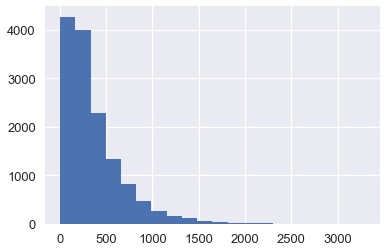

In [80]:
plt.hist(times, bins=20);

- We will take many samples from the population, compute a percentile CI and studentized CI for each sample, and compute the coverage.
- We repeat this for many sample sizes to see how the coverage changes with the sample size

- To compute percentile CI:

In [141]:
def percentile_ci(sample, reps=bootstrap_reps, stat=stat):
    stats = bootstrap_stats(sample, reps, stat)
    return np.percentile(stats, [2.5, 97.5])

In [146]:
np.random.seed(0)
sample = take_sample(n=10)
percentile_ci(sample)

array([157.53, 606.39])

- To compute studentized bootstrap, we need a lot more code:

In [147]:
def studentized_stats(sample, reps=bootstrap_reps, stat=stat):
    '''
    Computes studentized test statistics for the provided sample.
    
    Returns the studentized test statistics and the SD of the
    resample test statistics.
    '''
    # Bootstrap the sample and compute \tilde \theta values
    resamples = resample(sample, reps)
    resample_stats = stat(resamples, axis=1)
    resample_sd = np.std(resample_stats)
    
    # Compute SE of \tilde \theta.
    # Since we're estimating the sample mean, we can use the formula.
    # Without the formula, we would have to do a second level bootstrap here.
    resample_std_errs = np.std(resamples, axis=1) / np.sqrt(len(sample))
    
    # Compute studentized test statistics (q values)
    sample_stat = stat(sample)
    t_statistics = (resample_stats - sample_stat) / resample_std_errs
    return t_statistics, resample_sd
 
def studentized_ci(sample, reps=bootstrap_reps, stat=stat):
    '''
    Computes 95% studentized bootstrap CI
    '''
    t_statistics, resample_sd = studentized_stats(sample, reps, stat)
    lower, upper = np.percentile(t_statistics, [2.5, 97.5])
    
    sample_stat = stat(sample)
    return (sample_stat - resample_sd * upper,
            sample_stat - resample_sd * lower)

In [148]:
np.random.seed(0)
sample = take_sample(n=10)
studentized_ci(sample)

(133.95387091546283, 1277.7006485402687)

- Now, we compare coverages of these two methods as the sample size increases from 4 to 100.

In [92]:
def coverage(cis, parameter=theta):
    return (
        np.count_nonzero([lower < parameter < upper for lower, upper in cis])
        / len(cis)
    )

In [97]:
def run_trials(sample_sizes):
    np.random.seed(0)
    percentile_coverages = []
    studentized_coverages = []
    
    for n in sample_sizes:
        samples = [take_sample(n) for _ in range(samples_from_pop)]
        percentile_cis = [percentile_ci(sample) for sample in samples]
        studentized_cis = [studentized_ci(sample) for sample in samples]
        
        percentile_coverages.append(coverage(percentile_cis))
        studentized_coverages.append(coverage(studentized_cis))
    return pd.DataFrame({
        'percentile': percentile_coverages,
        'studentized': studentized_coverages,
    }, index=sample_sizes)

In [98]:
%%time

trials = run_trials(np.arange(4, 101, 2))

/Users/sam/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in true_divide


CPU times: user 2min 35s, sys: 7.89 s, total: 2min 43s
Wall time: 2min 46s


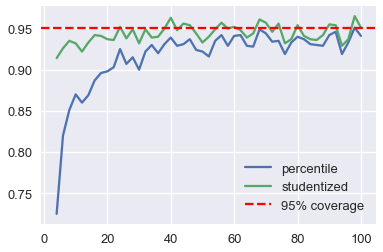

In [99]:
trials.plot()
plt.axhline(0.95, c='red', linestyle='--', label='95% coverage')
plt.legend();

- The studentized bootstrap has much better coverage at small sample sizes

## Summary

- Studentized bootstrap has better coverage than percentile bootstrap, especially at small samples sizes
- We use this method when sample size is small or when original data is skewed
- However, it requires more computation, especially when SE of statistic is not easy to compute.